# Data Inspection

## Packages

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import pycountry

## Load Data

In [19]:
country_df = pd.read_pickle("../../data/generated/country_df.pkl")
comes_from_df = pd.read_pickle("../../data/generated/comes_from_df.pkl")
genre_df = pd.read_pickle("../../data/generated/genre_df.pkl")
is_of_type_df = pd.read_pickle("../../data/generated/is_of_type_df.pkl")
language_df = pd.read_pickle("../../data/generated/language_df.pkl")
spoken_languages_df = pd.read_pickle("../../data/generated/spoken_languages_df.pkl")
character_df = pd.read_pickle("../../data/generated/character_df.pkl")
actor_df = pd.read_pickle("../../data/generated/actor_df.pkl")
movie_df = pd.read_pickle("../../data/generated/movie_df.pkl")
belongs_to_df = pd.read_pickle("../../data/generated/belongs_to_df.pkl")
play_df = pd.read_pickle("../../data/generated/play_df.pkl")
appears_in_df = pd.read_pickle("../../data/generated/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")

## Country

Movie Distribution Among Countries

#### Country Aggregation

Some countries are duplicated because for example of different time scales (e.g. nazi germany, west germany, recent germany). Then we have to aggregate them together.

In [21]:
COUNTRY_MAPPING = {"west germany": "germany", "weimar republic": "germany",
"german democratic republic": "germany",
"nazi germany": "germany", "german language": "germany",
"soviet union": "russia", "soviet occupation zone": "russia",
"socialist federal republic of yugoslavia": "yugoslavia", 
"federal republic of yugoslavia" : "yugoslavia",
"uzbek ssr" : "uzbekistan",
"georgian ssr": "georgia",
"kingdom of great britain": "united kingdom", "northern ireland": "united kingdom",
"wales": "united kingdom", "england": "united kingdom", "scotland": "united kingdom",
"serbia and montenegro" : "serbia and montenegro",
"kingdom of italy": "italy",
"mandatory palestine": "palestinian territories",
"ukranian ssr": "ukraine", "ukrainian ssr": "ukraine",
"malayalam language": "india",
"slovak republic" : "slovakia", "republic of china": "china"}

In [22]:
serbia_and_montenegro_ids = comes_from_df[
    comes_from_df["country_name"] == "serbia and montenegro"]["movie_id"].to_list()
comes_from_df = comes_from_df[comes_from_df["country_name"] != "serbia and montenegro"]
new_serbia_entries = pd.DataFrame(
    zip(serbia_and_montenegro_ids,["serbia"]*len(serbia_and_montenegro_ids)),
    columns=["movie_id","country_name"])
new_montenegro_entries = pd.DataFrame(
    zip(serbia_and_montenegro_ids,["montenegro"]*len(serbia_and_montenegro_ids)),
    columns=["movie_id","country_name"])
comes_from_df = pd.concat([comes_from_df,new_serbia_entries,new_montenegro_entries]).drop_duplicates()

In [23]:
comes_from_df["country_name"] = comes_from_df["country_name"].apply(lambda c: COUNTRY_MAPPING[c] if c in COUNTRY_MAPPING.keys() else c)

#### Bar Plot

In [24]:
country_count_df = comes_from_df.groupby("country_name").count().sort_values("movie_id",key=lambda l: -l)
country_count_df.columns = ["movie_count"]
country_log_count_df = country_count_df.apply(np.log)

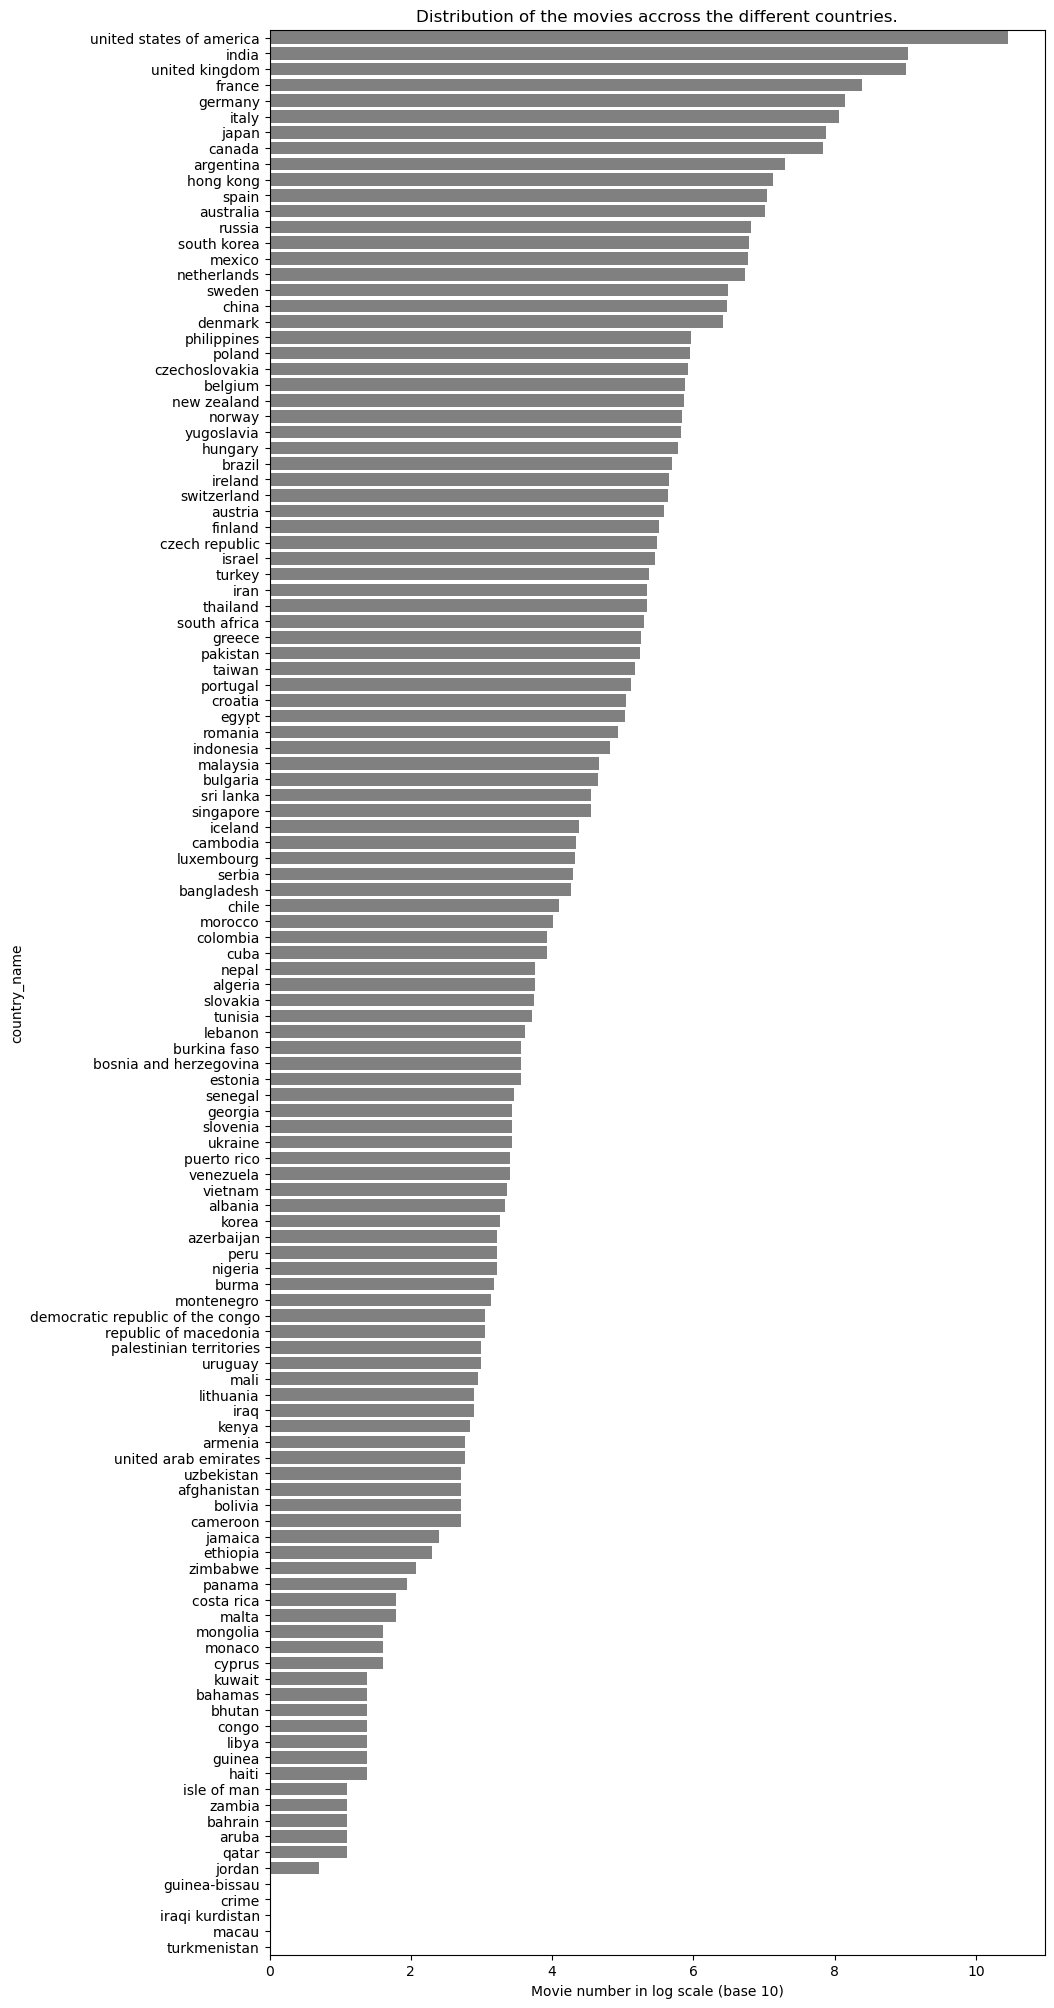

In [25]:
fig, ax = plt.subplots(1,figsize=(10,25))
ax.set_title("Distribution of the movies accross the different countries.")
sns.barplot(x=country_log_count_df.movie_count,y=country_log_count_df.index,
            orient="h",ax=ax, color="grey")#,palette=sns.color_palette("rocket",n_colors=len(a.index)));
ax.set_xlabel("Movie number in log scale (base 10)");

#### World Map 

In [26]:
CUSTOM_ALPHA3_CODE_MAPPING = {"bolivia":"BOL","burma":"BUR",
"czech republic":"CZE","czechoslovakia":"CSK",
"democratic republic of the congo":"COD","england":"GBR",
"federal republic of yugoslavia":"YUG","georgian ssr": "GEO",
"german democratic republic":"DEU","german":"DEU",
"iran":"IRN","kingdom of great britain":"GBR",
"kingdom of italy":"ITA","korea":"KOR",
"macau":"MAC","mandatory palestine":"PSE",
"nazi germany":"DEU","northern ireland":"GBR",
"palestinian territories":"PSE","republic of china":"CHN",
"republic of macedonia":"MKD","russia":"RUS",
"scotland":"GBR","serbia and montenegro":"SCG",
"slovak republic":"SVK","socialist federal republic of yugoslavia":"YUG",
"south korea":"KOR","soviet occupation zone":"RUS",
"soviet union":"RUS","taiwan":"TWN",
"ukrainian ssr":"UKR","ukranian ssr":"UKR",
"united states of america":"USA","uzbek ssr":"UZB",
"venezuela":"VEN","vietnam":"VNM",
"wales":"GBR","weimar republic":"DEU",
"west germany":"DEU","yugoslavia":"YUG",
"german language":"DEU"}

In [27]:
def alpha3code(country:str)->str:
    """
    Get the ISO_3166-1 alpha-3 code for the given country.
    
    :param country: Country name.
    
    :return: Three letters alpha-3 code, or "None" if not available.
    """
    CODE = "None"
    try:
        CODE = pycountry.countries.get(name=country).alpha_3
    except:
        if country in CUSTOM_ALPHA3_CODE_MAPPING.keys():
            CODE = CUSTOM_ALPHA3_CODE_MAPPING[country]
    return CODE

In [29]:
country_code_log_count_df = country_log_count_df.reset_index()
country_code_log_count_df["CODE"] = country_code_log_count_df["country_name"].apply(alpha3code)
country_code_log_count_df = country_code_log_count_df.set_index("country_name")

In [30]:
world_countries_df = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
world_countries_df.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
world_wrong_code_ids = world_countries_df["CODE"] == "-99"
world_wrong_code = world_countries_df[world_wrong_code_ids]
world_countries_df.loc[world_wrong_code_ids,"CODE"] = world_wrong_code["name"].apply(alpha3code)
world_merge = world_countries_df.merge(country_code_log_count_df,on='CODE')
world_merge = world_merge[~(world_merge["CODE"] == "None")]

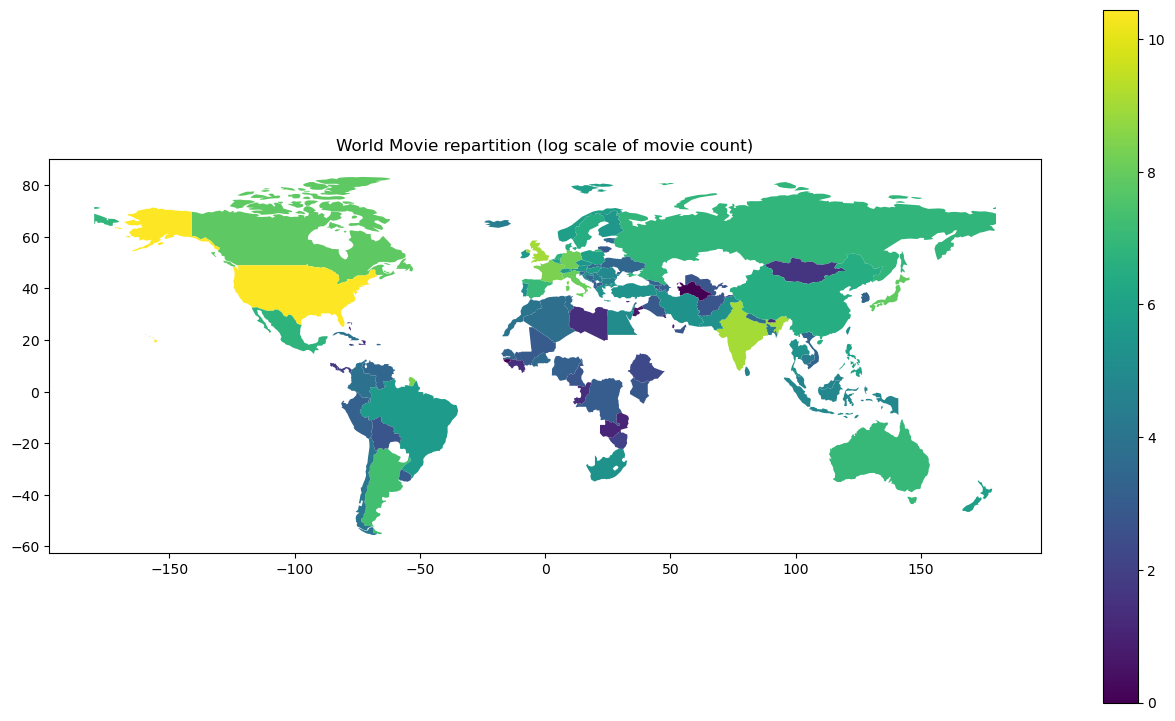

In [31]:
fig,ax = plt.subplots(1,figsize=(16,9))
ax.set_title("World Movie repartition (log scale of movie count)")
world_merge.plot(column="movie_count",legend=True,ax=ax);

### Top and bottom countries

In [40]:
print("The top 10 countries are:\n")
print(country_count_df.head(10).to_markdown())
print("\nThe bottom 10 countries are:\n")
print(country_count_df.tail(10).to_markdown())

The top 10 countries are:

| country_name             |   movie_count |
|:-------------------------|--------------:|
| united states of america |         34408 |
| india                    |          8413 |
| united kingdom           |          8153 |
| france                   |          4395 |
| germany                  |          3454 |
| italy                    |          3168 |
| japan                    |          2647 |
| canada                   |          2534 |
| argentina                |          1468 |
| hong kong                |          1240 |

The bottom 10 countries are:

| country_name    |   movie_count |
|:----------------|--------------:|
| zambia          |             3 |
| bahrain         |             3 |
| aruba           |             3 |
| qatar           |             3 |
| jordan          |             2 |
| guinea-bissau   |             1 |
| crime           |             1 |
| iraqi kurdistan |             1 |
| macau           |             1 |
| turk

### Descriptive statistics
Our data has a heavy tail, with a lot of countries having only a few movies. We will thus robust statistics.

In [41]:
country_median = country_count_df.median().item()
print(f"The median number of movies per country is {country_median}.")

The median number of movies per country is 42.5.


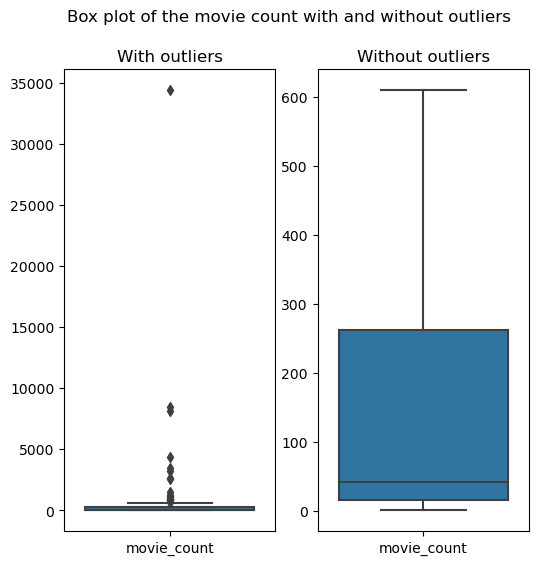

In [42]:
fig,axs = plt.subplots(1,2,figsize=(6,6))
fig.suptitle("Movie count per country with and without outliers")
sns.boxplot(country_count_df,ax=axs[0])
axs[0].set_title("With outliers")
sns.boxplot(country_count_df,showfliers=False,ax=axs[1])
axs[1].set_title("Without outliers");

## Languages

As for countries, we expect our dataset to be heavy tail with some languages only spoken in a few movies.

#### Bar Plot

In [50]:
language_count_df = spoken_languages_df.groupby("language_name").count().sort_values("movie_id",key=lambda l: -l)
language_count_df.columns = ["movie_count"]
language_log_count_df = language_count_df.apply(np.log)

C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66622 (\N{DESERET SMALL LETTER JEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66610 (\N{DESERET SMALL LETTER SHORT O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66633 (\N{DESERET SMALL LETTER ER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66635 (\N{DESERET SMALL LETTER EM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66636 (\N{DESERET SMALL LETTER EN}) missing from current fo

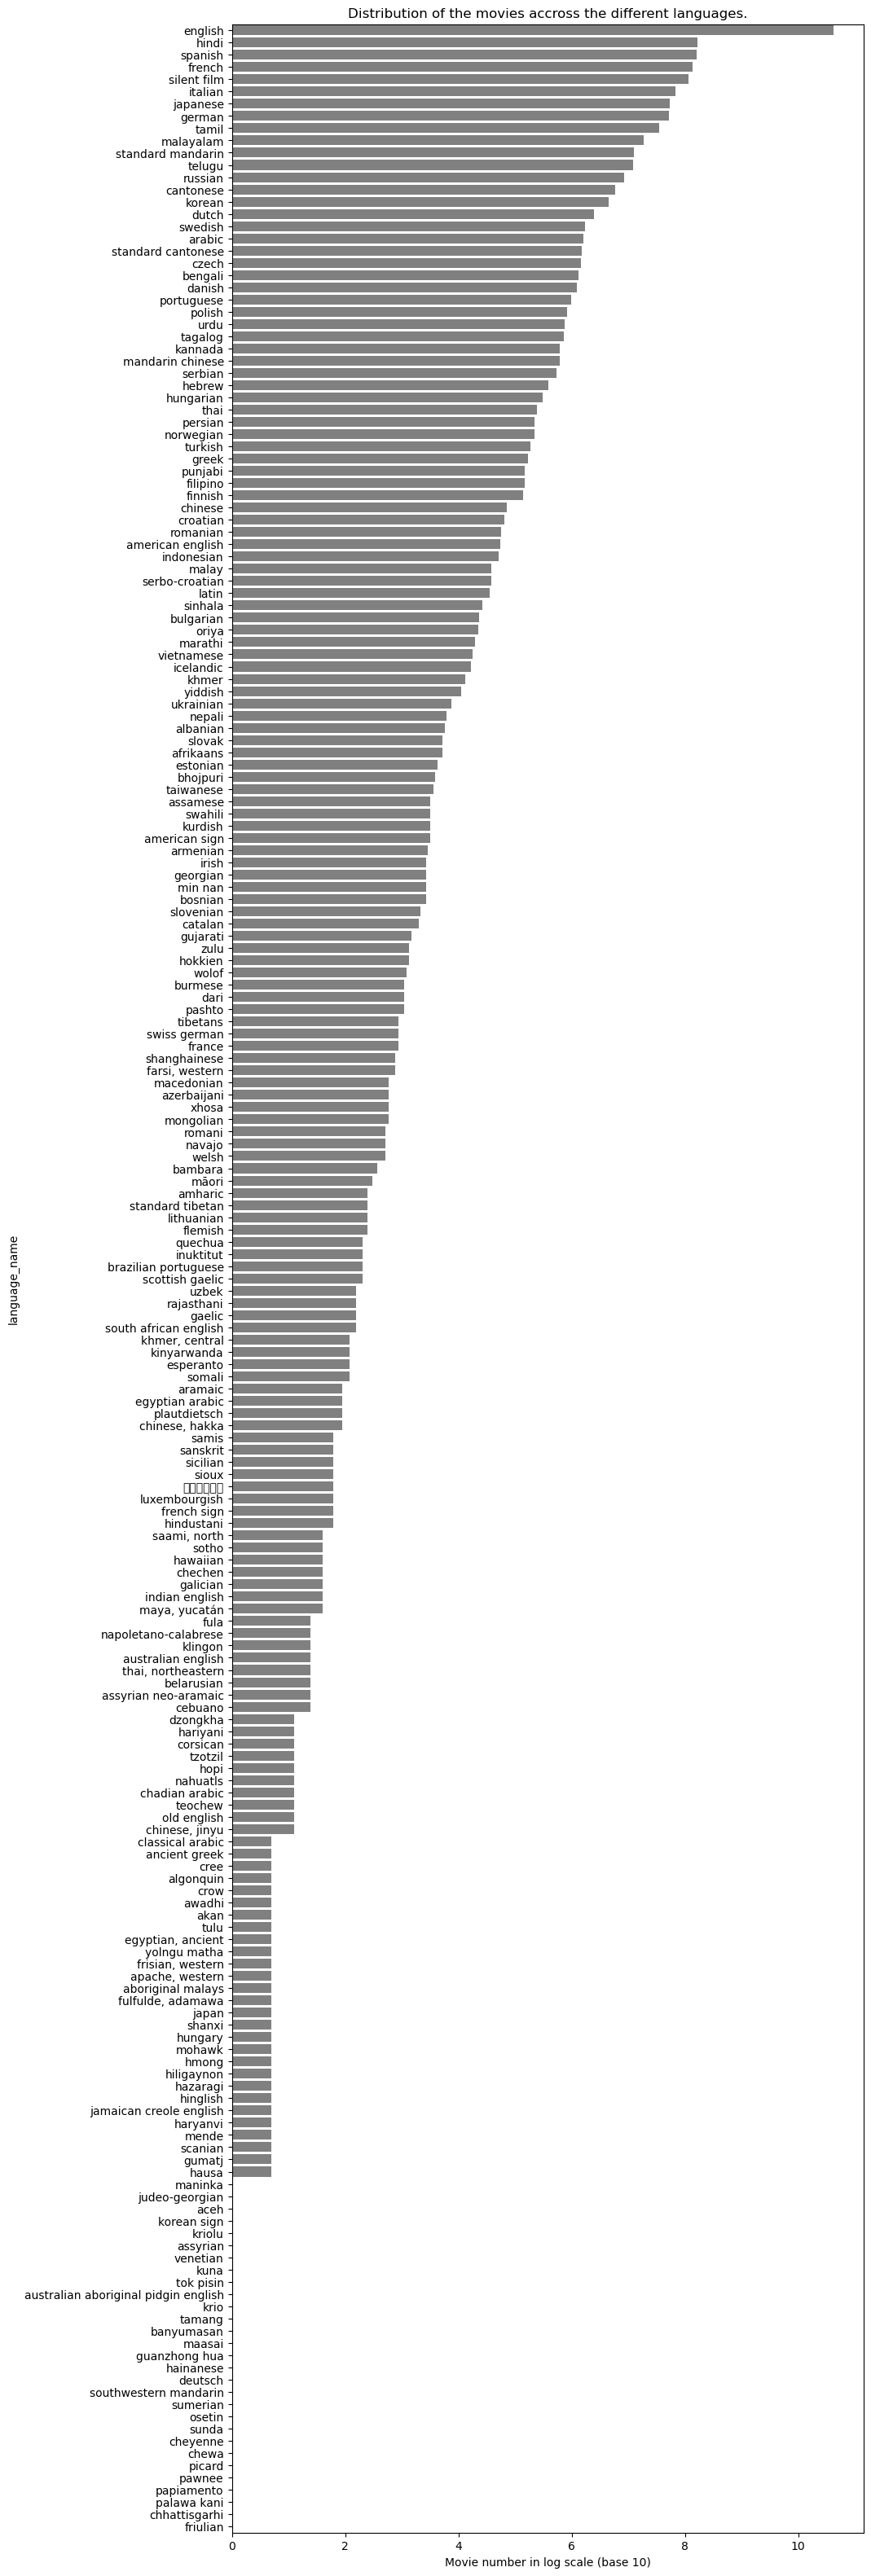

In [58]:
fig, ax = plt.subplots(1,figsize=(10,40))
ax.set_title("Distribution of the movies accross the different languages.")
sns.barplot(x=language_log_count_df.movie_count,y=language_log_count_df.index,
            orient="h",ax=ax, color="grey")#,palette=sns.color_palette("rocket",n_colors=len(a.index)));
ax.set_xlabel("Movie number in log scale (base 10)");

#### Box Plot

In [55]:
language_median = language_count_df.median().item()
print(f"The median number of movies per language is {language_median}.")

The median number of movies per language is 10.0.


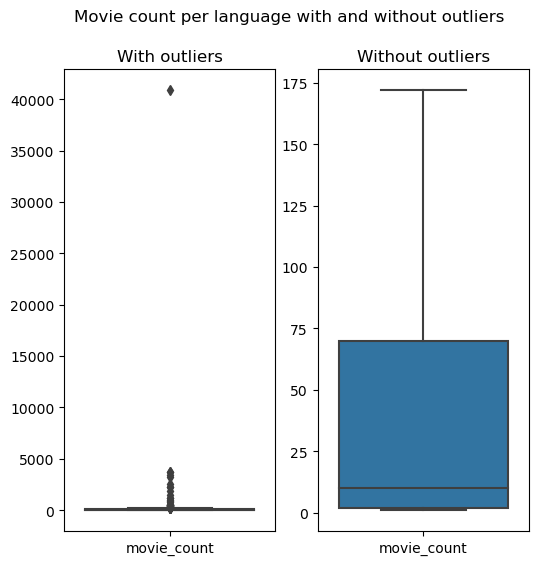

In [57]:
fig,axs = plt.subplots(1,2,figsize=(6,6))
fig.suptitle("Movie count per language with and without outliers")
sns.boxplot(language_count_df,ax=axs[0])
axs[0].set_title("With outliers")
sns.boxplot(language_count_df,showfliers=False,ax=axs[1])
axs[1].set_title("Without outliers");

### Top and bottom languages

In [59]:
print("The top 10 languages are:\n")
print(language_count_df.head(10).to_markdown())
print("\nThe bottom 10 languages are:\n")
print(language_count_df.tail(10).to_markdown())

The top 10 languages are:

| language_name   |   movie_count |
|:----------------|--------------:|
| english         |         40891 |
| hindi           |          3744 |
| spanish         |          3673 |
| french          |          3422 |
| silent film     |          3183 |
| italian         |          2532 |
| japanese        |          2295 |
| german          |          2262 |
| tamil           |          1896 |
| malayalam       |          1448 |

The bottom 10 languages are:

| language_name   |   movie_count |
|:----------------|--------------:|
| osetin          |             1 |
| sunda           |             1 |
| cheyenne        |             1 |
| chewa           |             1 |
| picard          |             1 |
| pawnee          |             1 |
| papiamento      |             1 |
| palawa kani     |             1 |
| chhattisgarhi   |             1 |
| friulian        |             1 |
